# Exploring Field Data: an example notebook

## Setting up the environment: pip install and import

In [1]:
! pip install -q pandas numpy matplotlib shapely geopandas cartopy

In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import cartopy.crs as ccrs
import cartopy.feature as cfeature


## Downloading and opening data

In [3]:
! wget -q https://wifire-data.sdsc.edu/nc/public.php/dav/files/nnSMqWfZAN6Cz6m/new_data/field_data/01_plot_identification.csv
! wget -q https://wifire-data.sdsc.edu/nc/public.php/dav/files/nnSMqWfZAN6Cz6m/new_data/field_data/03_tree.csv

In [4]:
df_plots = pd.read_csv("01_plot_identification.csv")
df_trees = pd.read_csv("03_tree.csv")

## Inspecting the columns of the dataframes

In [5]:
def print_column_names(df):
    cols = 4
    for i, col in enumerate(df.columns):
        last_col = (i + 1) % cols == 0
        end = "\n" if last_col else " "
        print(f"{col:30}", end=end)

In [6]:
print_column_names(df_plots)

inventory_id                   site_project                   site_project_label             site_name                     
site_name_label                inventory_pre_post_fire        inventory_pre_post_fire_label  plot_num                      
plot_blk                       inventory_date                 inventory_hour                 plot_coord_x                  
plot_coord_y                   plot_coord_srs                 plot_declination               inventory_plot_diam           
plot_slopeper                  plot_aspectdegre               plot_wtreetag_yn               plot_wtreetag                 
plot_wtreesp                   plot_wtreesp_scientific_name   plot_wtreesp_vernacular_name   plot_wtreedbh                 
plot_wtreeazimuth_deg          plot_wtreedistance_m           inventory_photon_file_uuid     inventory_photon_file_name    
inventory_photoe_file_uuid     inventory_photoe_file_name     inventory_photos_file_uuid     inventory_photos_file_name    
inventor

In [7]:
print_column_names(df_trees)

inventory_id                   tree_id                        tree_tag                       tree_sp                       
tree_sp_scientific_name        tree_sp_vernacular_name        tree_status                    tree_status_label             
tree_dbh                       tree_firedamage                tree_burn                      tree_ht                       
tree_htlcb                     tree_resprouting               tree_decay_class               tree_decay_class_label        
treepost_scorch_m              treepost_scorch_per            treepost_torch_m               treepost_torch_per            
treepost_bole_char_m           tree_notes                     

## Inspecting the rows of the dataframes

In [8]:
#
# Thats a lot of columns
# Lets look at entries for a few of them
#

In [9]:
#
# Plots dataframe
#
with pd.option_context("display.width", 120):
    cols = ["inventory_id", "plot_coord_x", "plot_coord_y", "site_name", "site_name_label", "inventory_date"]
    print(df_plots[cols])

           inventory_id  plot_coord_x  plot_coord_y site_name              site_name_label inventory_date
0    143_pre_SHA_burn3d        297590       4108796       SHA            Shaver Lake (SHA)        7/21/24
1    140_pre_SHA_burn3d        297640       4108747       SHA            Shaver Lake (SHA)        7/21/24
2    152_pre_SHA_burn3d        297694       4108903       SHA            Shaver Lake (SHA)        7/21/24
3    147_pre_SHA_burn3d        297646       4108845       SHA            Shaver Lake (SHA)        7/20/24
4    151_pre_SHA_burn3d        297603       4108893       SHA            Shaver Lake (SHA)        7/20/24
..                  ...           ...           ...       ...                          ...            ...
158   40_pre_puc_burn3d        551174       4269175       puc  Pacific Union College (PUC)        11/8/24
159   41_pre_puc_burn3d        551260       4269177       puc  Pacific Union College (PUC)        11/8/24
160   45_pre_puc_burn3d        551220       42

In [10]:
#
# Trees dataframe
#
with pd.option_context("display.width", 120):
    # dbh: Diameter at Breast Height
    cols = ["inventory_id", "tree_id", "tree_sp_scientific_name", "tree_status", "tree_dbh"]
    print(df_trees[cols])

            inventory_id  tree_id    tree_sp_scientific_name tree_status  tree_dbh
0     143_pre_SHA_burn3d        1             Abies concolor        Live       8.2
1     143_pre_SHA_burn3d        2             Abies concolor        Live      54.6
2     143_pre_SHA_burn3d        3             Abies concolor        Live      86.9
3     143_pre_SHA_burn3d        4             Abies concolor        Live      21.7
4     143_pre_SHA_burn3d        5             Abies concolor        Live      45.3
...                  ...      ...                        ...         ...       ...
2142   46_pre_puc_burn3d       11  Notholicarpos densiflorus        Live      35.6
2143   46_pre_puc_burn3d       12  Notholicarpos densiflorus        Live      43.7
2144   46_pre_puc_burn3d       13      Pseudotsuga menziesii        Live      71.4
2145   46_pre_puc_burn3d       14          Arbutus menziesii        Live      31.9
2146   46_pre_puc_burn3d       15          Arbutus menziesii        Live      22.5

[21

## Where are the sites?

In [11]:
#
# Lets convert plot x,y into latitude,longitude and plot them on a map
#
print(df_plots[["site_name_label", "plot_coord_x", "plot_coord_y", "plot_coord_srs"]])

                 site_name_label  plot_coord_x  plot_coord_y  plot_coord_srs
0              Shaver Lake (SHA)        297590       4108796           26911
1              Shaver Lake (SHA)        297640       4108747           26911
2              Shaver Lake (SHA)        297694       4108903           26911
3              Shaver Lake (SHA)        297646       4108845           26911
4              Shaver Lake (SHA)        297603       4108893           26911
..                           ...           ...           ...             ...
158  Pacific Union College (PUC)        551174       4269175           26910
159  Pacific Union College (PUC)        551260       4269177           26910
160  Pacific Union College (PUC)        551220       4269331           26910
161  Pacific Union College (PUC)        551115       4269331           26910
162  Pacific Union College (PUC)        551166       4269380           26910

[163 rows x 4 columns]


In [12]:
#
# We can use x, y, and srs (Spatial Reference System) to derive latitude and longitude
#
gdfs = []
for crs in df_plots["plot_coord_srs"].unique():
    df_crs = df_plots[df_plots["plot_coord_srs"] == crs]
    geometry = [Point(xy) for xy in zip(df_crs["plot_coord_x"], df_crs["plot_coord_y"])]
    gdf = gpd.GeoDataFrame(df_crs, geometry=geometry, crs=f"EPSG:{crs}")
    gdf = gdf.to_crs(epsg=4326)
    gdfs.append(gdf)

# Recombine the GeoDataFrames
gdf = pd.concat(gdfs)
gdf["longitude"] = gdf.geometry.x
gdf["latitude"] = gdf.geometry.y
with pd.option_context("display.width", 140):
    print(gdf[["site_name_label", "latitude", "longitude"]])

                 site_name_label   latitude   longitude
0              Shaver Lake (SHA)  37.103626 -119.277812
1              Shaver Lake (SHA)  37.103196 -119.277236
2              Shaver Lake (SHA)  37.104613 -119.276671
3              Shaver Lake (SHA)  37.104080 -119.277195
4              Shaver Lake (SHA)  37.104503 -119.277692
..                           ...        ...         ...
158  Pacific Union College (PUC)  38.569555 -122.412565
159  Pacific Union College (PUC)  38.569568 -122.411578
160  Pacific Union College (PUC)  38.570958 -122.412025
161  Pacific Union College (PUC)  38.570965 -122.413231
162  Pacific Union College (PUC)  38.571403 -122.412642

[163 rows x 3 columns]


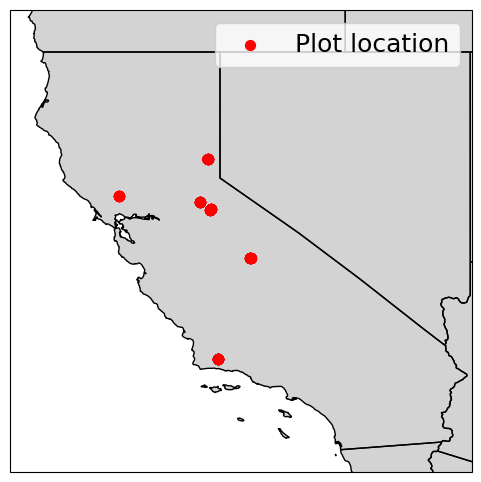

In [13]:
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Add features and focus on California
ax.add_feature(cfeature.STATES, edgecolor='black')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.set_extent([-125, -114, 32, 43], crs=ccrs.PlateCarree())
# [lon_min, lon_max, lat_min, lat_max]

ax.scatter(
    gdf['longitude'],
    gdf['latitude'],
    color='red',
    s=50,
    transform=ccrs.PlateCarree(),
    label='Plot location',
)

ax.legend(fontsize=18)


## How many plots are at each site?

In [14]:
col = "site_name_label"
for label in df_plots[col].unique():
    nplots = (df_plots[col] == label).sum()
    print(f"{nplots} plots from {label}")

25 plots from Shaver Lake (SHA)
21 plots from Independence Lake (IND)
40 plots from Sedgwick Reserve (SDR)
35 plots from Calaveras Big Trees State Park
25 plots from Winton-Schaads VMP (WIN)
17 plots from Pacific Union College (PUC)


## Adding site name to the tree DataFrame via `merge`

In [15]:
col = "site_name_label"
if col not in df_trees.columns:
    df_trees = df_trees.merge(df_plots[["inventory_id", col]], on="inventory_id", how="left")

print(df_trees[col])
print()
print("Unique site names:")
print("\n".join(df_trees[col].unique()))

0                 Shaver Lake (SHA)
1                 Shaver Lake (SHA)
2                 Shaver Lake (SHA)
3                 Shaver Lake (SHA)
4                 Shaver Lake (SHA)
                   ...             
2142    Pacific Union College (PUC)
2143    Pacific Union College (PUC)
2144    Pacific Union College (PUC)
2145    Pacific Union College (PUC)
2146    Pacific Union College (PUC)
Name: site_name_label, Length: 2147, dtype: object

Unique site names:
Shaver Lake (SHA)
Independence Lake (IND)
Sedgwick Reserve (SDR)
Calaveras Big Trees State Park
Winton-Schaads VMP (WIN)
Pacific Union College (PUC)


## A tree-level distribution: height vs diameter

Text(0.5, 1.0, '2D histogram of tree height and diameter')

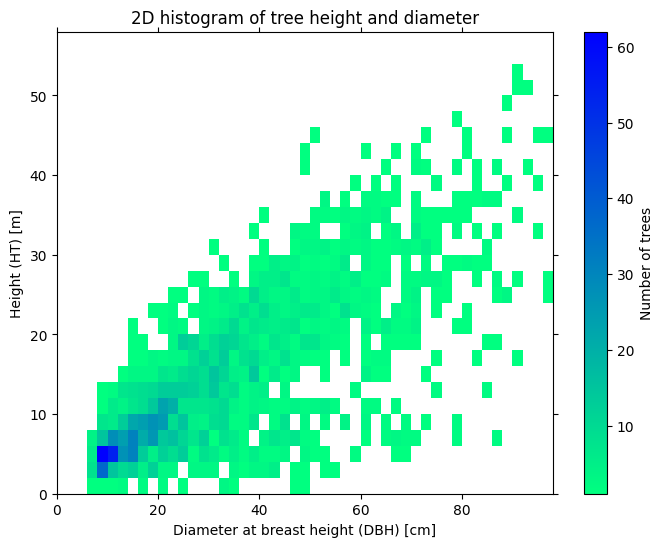

In [16]:
#
# For 2D, lets compare height and diameter
#
fig, ax = plt.subplots(figsize=(8, 6))

cmap, cmin = plt.cm.winter_r, 0.5
bins = (np.arange(0, 100, step=2), np.arange(0, 60, step=2))

_, _, _, im = ax.hist2d(df_trees["tree_dbh"], df_trees["tree_ht"], bins=bins, cmap=cmap, cmin=cmin)

cbar = fig.colorbar(im, ax=ax)
cbar.set_label("Number of trees")
ax.set_xlabel("Diameter at breast height (DBH) [cm]")
ax.set_ylabel("Height (HT) [m]")
ax.tick_params(top=True, right=True)
ax.set_title("2D histogram of tree height and diameter")